# Kevitsa Gravity Inversion

**Objective:** 

In this tutorial we will invert simulated gravity data over the Kevitsa Ni-Cu-PGE deposit.
The two main objectives are

1. Walk through the gravity inversion workflow with SimPEG
2. Determine the depth resolution of the gravity survey

Ultimately, we want to know if the recovered compact density model can delinate the shape and vertical extent of the Kevitsa intrusion. We will compare our density model to the published geological horizons picked from 2d/3D seismic survey.

**References**

Koivisto, E., Malehmir, A., Hellqvist, N., Voipio, T. and Wijns, C. (2015), Building a 3D model of lithological contacts and near-mine structures in the Kevitsa mining and exploration site, Northern Finland: constraints from 2D and 3D reflection seismic data. Geophysical Prospecting, 63: 754–773. doi:10.1111/1365-2478.12252

Here goes nothing...

In [1]:
# The usual, we need to load some libraries
from SimPEG import Mesh, Utils, Maps, PF
from SimPEG import mkvc, Regularization, DataMisfit, Optimization, InvProblem, Directives,Inversion
from SimPEG.Utils import mkvc
from SimPEG.Utils.io_utils import download
import numpy as np
import scipy as sp
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Download data from the cloud 
url = "https://storage.googleapis.com/simpeg/kevitsa_synthetic/"

cloudfiles = [
    'Mesh_global_100m_padded.msh','GravSim.dat',
    'Kevitsa.topo', 'SimPEG_GRAV.inp'
]
keys = ['mesh', 'data', 'topo', 'input']

# Download to ./KevitsaGrav
files = download([url+f for f in cloudfiles], folder='./KevitsaGrav', overwrite=True)
files = dict(zip(keys, files))  # allows us to name the files

# Read in the input file which included all parameters at once (mesh, topo, model, survey, inv param, etc.)
inputFile = files['input'] # input file was the last downloaded
driver = PF.GravityDriver.GravityDriver_Inv()
driver.basePath = './KevitsaGrav'

# All the parameters in the input files can be access via the driver object
# For example, to get the survey:
obs = driver.readGravityObservations(files['data'])
mesh = Mesh.TensorMesh.readUBC(files['mesh'])


overwriting Mesh_global_100m_padded.msh
overwriting GravSim.dat
overwriting Kevitsa.topo
overwriting SimPEG_GRAV.inp
Download completed!


## Setup

The relation between density and the gravity field is well known, thanks to the classic work of Newton in 1686. Since we generally only measure the vertical component of the field, this relationship can be written as:

$$G(r)_z = \gamma \int_{V}   \rho(r) \left(\frac{z - z_0}{{|\vec r - \vec r_0|}^3}\right) \; dV $$

where $\rho$ is the anomalous density and $\gamma$ is the Newton's gravitational constant.
This integral can be evaluated analytically for simple prisms, giving rise to a linear system of equations relating a discrete Earth to the observed data:

$$ \mathbf{d}_z =  \mathbf{F} \; \boldsymbol{\rho} $$


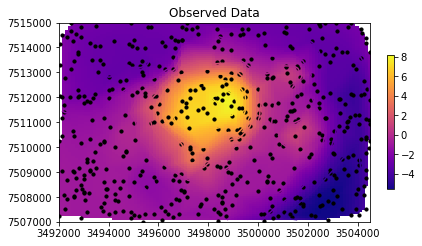

In [3]:
# The gridded data holds 20k+ observation points, too large for a quick inversion
# Let's grab a random subset
nD = 500
indx = randint(0,high=obs.dobs.shape[0],size=nD)

# Create a new downsampled survey
locXYZ  = obs.srcField.rxList[0].locs[indx,:]

rxLoc = PF.BaseGrav.RxObs(locXYZ)
srcField = PF.BaseGrav.SrcField([rxLoc])
survey = PF.BaseGrav.LinearSurvey(srcField)
survey.dobs = obs.dobs[indx]
survey.std = obs.std[indx]

ph = PF.Gravity.plot_obs_2D(survey.srcField.rxList[0].locs, survey.dobs,'Observed Data')

Number of data points: 500
Number of model cells: 106703


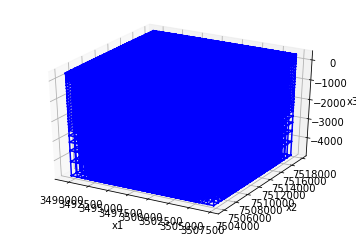

In [4]:
# Create a mesh, we will start coarse. Feel free to change the
# the mesh, but make sure you have enough memory and coffee brakes...
dx = 200.
npad = 5
hxind = [(dx, npad, -1.3), (dx, 65), (dx, npad, 1.3)]
hyind = [(dx, npad, -1.3), (dx, 45), (dx, npad, 1.3)]
hzind = [(dx, npad, -1.3), (150, 15), (10, 10, -1.3), (10,5)]

# Create the mesh and move the location to the center of the data
mesh = Mesh.TensorMesh([hxind, hyind, hzind], 'CC0')
mesh._x0 += [np.mean(locXYZ[:,0]), np.mean(locXYZ[:,1]), np.max(locXYZ[:,2])-np.sum(mesh.hz)]

ax = mesh.plotGrid()

# We will get the topography from the input file
topo = np.genfromtxt(files['topo'], skip_header=1)

# Find the active cells
actv = Utils.surface2ind_topo(mesh, topo, 'N')

actv = np.asarray(
    [inds for inds, elem in enumerate(actv, 1) if elem], dtype=int
) - 1

nC = len(actv)

print("Number of data points: " + str(nD))
print("Number of model cells: " + str(nC))

**Forward system:**

Now that we have all our spatial components, we can create our linear system relating the data and anomalous density:

$$ d^{obs} = \mathbf{F\; \rho}$$

where $\mathbf{F} \in \mathbb{R}^{nd \times nc}$ is our $forward$ operator.


In [ ]:
# Create active map to go from reduce set to full
actvMap = Maps.InjectActiveCells(mesh, actv, -100)

# Create reduced identity map
idenMap = Maps.IdentityMap(nP=nC)
mstart = np.ones(nC)*1e-4

# Create gravity problem
prob = PF.Gravity.GravityIntegral(mesh, rhoMap=idenMap, actInd=actv)

survey.pair(prob)

In [ ]:
# Make depth weighting, 
# this will also require the calculation of the forward operator ... time for coffee
wr = np.sum(prob.G**2., axis=0)**0.5
wr = (wr/np.max(wr))

Begin calculation of forward operator: z
Done 0.0 %


## Inverse problem

We have generated synthetic data, we now want to see if we can solve the inverse problem and recover our synthetic density model. Using the usual formulation, we seek a model that can reproduce the data, let’s say a least-squares measure of data fit of the form:

\begin{equation}
\phi_d =   \|\mathbf{W}_d \left( \mathbb{F}[\mathbf{m}] - \mathbf{d}^{obs} \right)\|_2^2
\end{equation}

The inverse problem is hard because we don’t have great data coverage, and the Earth is big, and there is usually noise in the data. So we need to add something to regularize it.
The simplest way to do it is to penalize solutions that won’t make sense geologically. For example we can assume that the model is smooth and that anomalous density should remain small.
The usual smooth inversion function use an l2-norm measure:

\begin{equation}
\phi_d =   \|\mathbf{W}_d \left( \mathbb{F}[\mathbf{m}] - \mathbf{d}^{obs} \right)\|_2^2 \\
\phi_m = \beta \Big [ {\| \mathbf{W}_s \;( \mathbf{m - m^{ref}})\|}^2_2  + \sum_{i = x,y,z}  {\|   \mathbf{W}_i  \; \mathbf{G}_i \; \mathbf{m}\|}^2_2  \Big ]\;,
\end{equation}

The full objective function to be minimized can be written as:

\begin{equation}
\phi(m) =  \phi_d + \beta \phi_m\;,
\end{equation}

which will yield our usual *small* and *smooth* models. 

We propose a fancier regularization function that can allow to recover *sparse* and *blocky* solutions.
Starting with the well known Ekblom norm:
\begin{equation}
\phi_m =  \sum_{i=1}^{nc} {(x_i^2 + \epsilon^2)}^{p/2} \;,
\end{equation}
where $x_i$ denotes some function of the model parameter, and $\epsilon$ is a small value to avoid singularity as $m\rightarrow0$.
For p=2, we get the usual least-squares measure and we recover the regularization presented above. For $p \leq 1$, the function becomes non-linear which requires some tweaking.

We can linearize the function by updating the penality function iteratively, commonly known as an Iterative Re-weighted Least-Squares (IRLS) method:

\begin{equation} 
\phi_m^{(k)} =  \frac{1}{2}\sum_{i=1}^{nc} r_i \; x_i^2
\end{equation}

where we added the superscript $\square^{(k)}$ to denote the IRLS iterations. The weights $r(x)$ are computed from model values obtained at a previous iteration such that:

\begin{equation}
	{r}_i  ={\Big( {({x_i}^{(k-1)})}^{2} + \epsilon^2 \Big)}^{p/2 - 1} \;,
\end{equation}

where ${r}(x) \in \mathbb{R}^{nc}$.

In matrix form, our objective function simply becomes:

\begin{equation}
\phi(m) =   \|\mathbf{W}_d \left( \mathbb{F}[\mathbf{m}] - \mathbf{d}^{obs} \right)\|_2^2 + \beta \Big [ {\| \mathbf{W}_s \;\mathbf{R}_s\;( \mathbf{m - m^{ref}})\|}^2_2  + \sum_{i = x,y,z}  {\|   \mathbf{W}_i\; \mathbf{R}_i  \; \mathbf{G}_i \; \mathbf{m}\|}^2_2  \Big ]\;,
\end{equation}

where the IRLS weights $\mathbf{R}_s$ and $\mathbf{R}_i$ are diagonal matrices defined as:

\begin{equation}
\begin{split}
	{R}_{s_{jj}}  &=  \sqrt{\eta_p}{\Big[ {({m_j}^{(k-1)})}^{2} + \epsilon_p^2 \Big]}^{(p/2 - 1)/2} \\
	{R}_{i_{jj}}  &=  \sqrt{\eta_q}{\Big[ {\left ({{(G_i\;m^{(k-1)})}_j }\right)}^{2} + \epsilon_q^2 \Big]}^{(q/2 - 1)/2} \\
\eta_p &=  {\epsilon_p}^{(1-p/2)} \\
\eta_q &=   {\epsilon_q}^{(1-q/2)}  \;, 
\end{split}
\end{equation}

we added two scaling parameters $\eta_p$ and $\eta_q$ for reasons that we won't dicuss here, but turn out to be important to get stable solves.

In order to initialize the IRLS and get an estimate for the stabilizing parameters $\epsilon_p$ and $\epsilon_q$, we first invert with the smooth $l_2$-norm. 
The whole IRLS process is implemented with a directive added to the inversion workflow (see below).


In [ ]:
# % Create inversion objects
reg = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap)
reg.cell_weights = wr
reg.norms = [0,2,2,2]


opt = Optimization.ProjectedGNCG(maxIter=100, lower=-.5,upper=0.5, maxIterLS = 20, maxIterCG= 10, tolCG = 1e-3)
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.W = 1./survey.std

# This is where the misfit function and regularization are put together
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)

# Here are few directives to make the inversion work and apply sparsity.
# After the l2, beta is re-adjusted on the fly to stay near the target misfit
betaest = Directives.BetaEstimate_ByEig()
IRLS = Directives.Update_IRLS(f_min_change=1e-4, minGNiter=3)
update_Jacobi = Directives.Update_lin_PreCond()
inv = Inversion.BaseInversion(invProb, directiveList=[betaest, IRLS,
                                                      update_Jacobi])
# Run the inversion
mrec = inv.run(mstart)

### View the inversion results 

In [ ]:
# Here is a quick script to slice through the final model
import ipywidgets as widgets

def ModSlicer(mesh, model):

    
    def plotIt(m, normal, panel, vmin, vmax):

        
        ypanel = int(mesh.vnC[1]/2)
        plt.figure(figsize=(10, 8))
        ax = plt.subplot(211)
        ph = mesh.plotSlice(model[m], ax=ax, normal=normal, ind=int(panel),
                       grid=True,
                       clim=(vmin,vmax), pcolorOpts={'cmap': 'jet', })
        

        # Set default limits
        if normal == 'X':
            Xlim = [mesh.vectorNy.min(), mesh.vectorNy.max()] 
            Ylim = [mesh.vectorNz.min(), mesh.vectorNz.max()] 
        elif normal == 'Y':
            Xlim = [mesh.vectorNx.min(), mesh.vectorNx.max()] 
            Ylim = [mesh.vectorNz.min(), mesh.vectorNz.max()]  
        else:
            Xlim = [mesh.vectorNx.min(), mesh.vectorNx.max()] 
            Ylim = [mesh.vectorNy.min(), mesh.vectorNy.max()]  
            
        ax.set_xlim(Xlim)
        ax.set_ylim(Ylim)
        ax.set_aspect('equal')
        plt.colorbar(ph[0])
        plt.title('Plan lp-model.')
        plt.gca().set_aspect('equal')
        plt.ylabel('y')
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()
        
    out = widgets.interactive(plotIt,
                              m = widgets.ToggleButtons(
                                        options=['l2', 'lp'],
                                        description='Model:'),
                              normal = widgets.ToggleButtons(
                                        options=['X', 'Y', 'Z'],
                                        description='Normal:',
                                        disabled=False,
                                        button_style='', # 'success', 'info', 'warning', 'danger' or ''
                                        tooltip='Description'),
                              panel = widgets.FloatSlider(min=0, max=mesh.vnC.max(), step=1,value=1, continuous_update=False),
                              vmin = widgets.FloatSlider(min=model['l2'][~np.isnan(model['l2'])].min(), max=model['l2'][~np.isnan(model['l2'])].max(), step=0.001,value=model['l2'][~np.isnan(model['l2'])].min(), continuous_update=False),
                              vmax = widgets.FloatSlider(min=model['l2'][~np.isnan(model['l2'])].min(), max=model['l2'][~np.isnan(model['l2'])].max(), step=0.001,value=model['l2'][~np.isnan(model['l2'])].max(), continuous_update=False),
)
    return out

# Plot the result
m_lp = actvMap * mrec
m_lp[m_lp == -100] = np.nan

m_l2 = actvMap*IRLS.l2model
m_l2[m_l2 == -100] = np.nan

model={'l2':m_l2,'lp':m_lp}

In [ ]:
# Execute the ploting function
ModSlicer(mesh, model)